## Cодержание:
* [First Bullet Header](#first-bullet)
* [Second Bullet Header](#second-bullet)

# Команда: Бета Банк


**Цель:** Создать CLTV модель, которая будет выдавать вероятности перехода в каждый из 17 продуктовых кластеров в течение 12 месяцев.

Альфа-Банком предоставлены следующие **данные**, описание из файла **feature_description.xlsx**:

-   **`train_data.pqt`и `test_data.pqt` – данные о клиентах за 3 месяца:**
   
    Возможно тут описание длатасета
    - `st_id` – захэшированное id магазина;
    - `pr_sku_id` – захэшированное id товара;
    - `date` – дата;
    - `pr_sales_type_id` – флаг наличия промо;
    - `pr_sales_in_units` – число проданных товаров без признака промо;
    - `pr_promo_sales_in_units` – число проданных товаров с признаком промо;
    - `pr_sales_in_rub` – продажи без признака промо в РУБ;
    - `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ;


  
Метрикой качества выступает **ROC-AUC**.

Данные о клиентах и масскированы.

## Библиотеки

In [122]:
def plt_null_df(df):

    plt.figure(figsize=(30, 18))

    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')

    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")

    plt.show()
    
def plt_corr_df(df):

  corr_df = df.select_dtypes(include='number').corr().abs()
  mask = np.triu(np.ones_like(corr_df, dtype=bool))

  plt.figure(figsize=(40, 30))
  sns.heatmap(corr_df, cmap="YlGnBu", annot=True,
              fmt=".1f", annot_kws={'size': 5}, mask=mask)
  plt.show()

In [123]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [124]:
# Необходимые библиотеки
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
import warnings
from IPython.display import display, HTML


import os
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
# import optuna
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

# Отключить все предупреждения временно
import warnings
warnings.filterwarnings("ignore")

## Задание

1. Качественно оформите код модели
2. Доработка решения на платформе будет открыта до 18 апреля 12:00
3. Обязательно наличие .README;
4. Код должен быть читабелен и понятен;
5. Решение должно быть воспроизводимо: эксперты должны иметь возможность протестировать ваше решение на финале.

## Загрузка и изучение данных

In [125]:
def read_df(path: str) -> pd.DataFrame:
    """
    Функция для чтения DataFrame из Parquet-файла.

    Параметры:
    path (str): Путь к Parquet-файлу.

    Возвращает:
    pd.DataFrame: DataFrame, прочитанный из Parquet-файла.

    """
    if os.path.exists(path):
        df = pd.read_parquet(path)
        print(f'Успешно: Данные {path} загружены')
        return df
    else:
        print(f'Ошибка: {path} не найден')
        return None

In [126]:
# from google.colab import drive
# drive.mount('/content/drive')

In [127]:
# Путь до файла train_df
path_train_df = "/kaggle/input/alfa-hackaton/train_data.pqt"

# Путь до файла test_df
path_test_df = "/kaggle/input/alfa-hackaton/test_data.pqt"

# # Путь до файла train_df
# path_train_df = "/content/drive/MyDrive/Alfa-hak/train_data.pqt"

# # Путь до файла test_df
# path_test_df = "/content/drive/MyDrive/Alfa-hak/test_data.pqt"


train_df = read_df(path=path_train_df)
test_df = read_df(path=path_test_df)

Успешно: Данные /kaggle/input/alfa-hackaton/train_data.pqt загружены
Успешно: Данные /kaggle/input/alfa-hackaton/test_data.pqt загружены


## Предобработка данных

### Объединение датасетов


In [128]:
df = pd.concat([train_df, test_df], ignore_index=True)

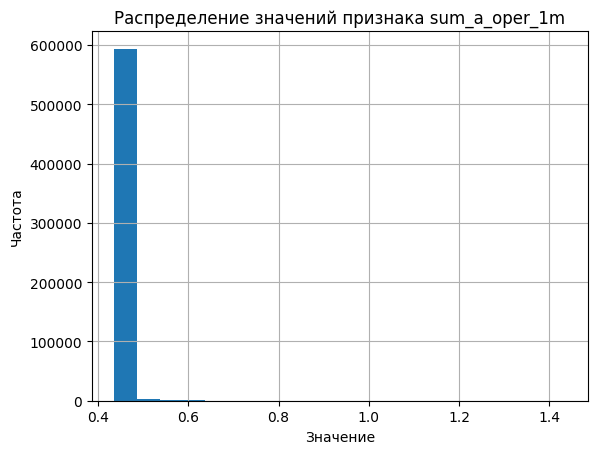

In [129]:
df['cnt_b_oper_1m'].hist(bins=20)  # Вы можете выбрать количество корзин (bins) по вашему усмотрению
plt.title('Распределение значений признака sum_a_oper_1m')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()

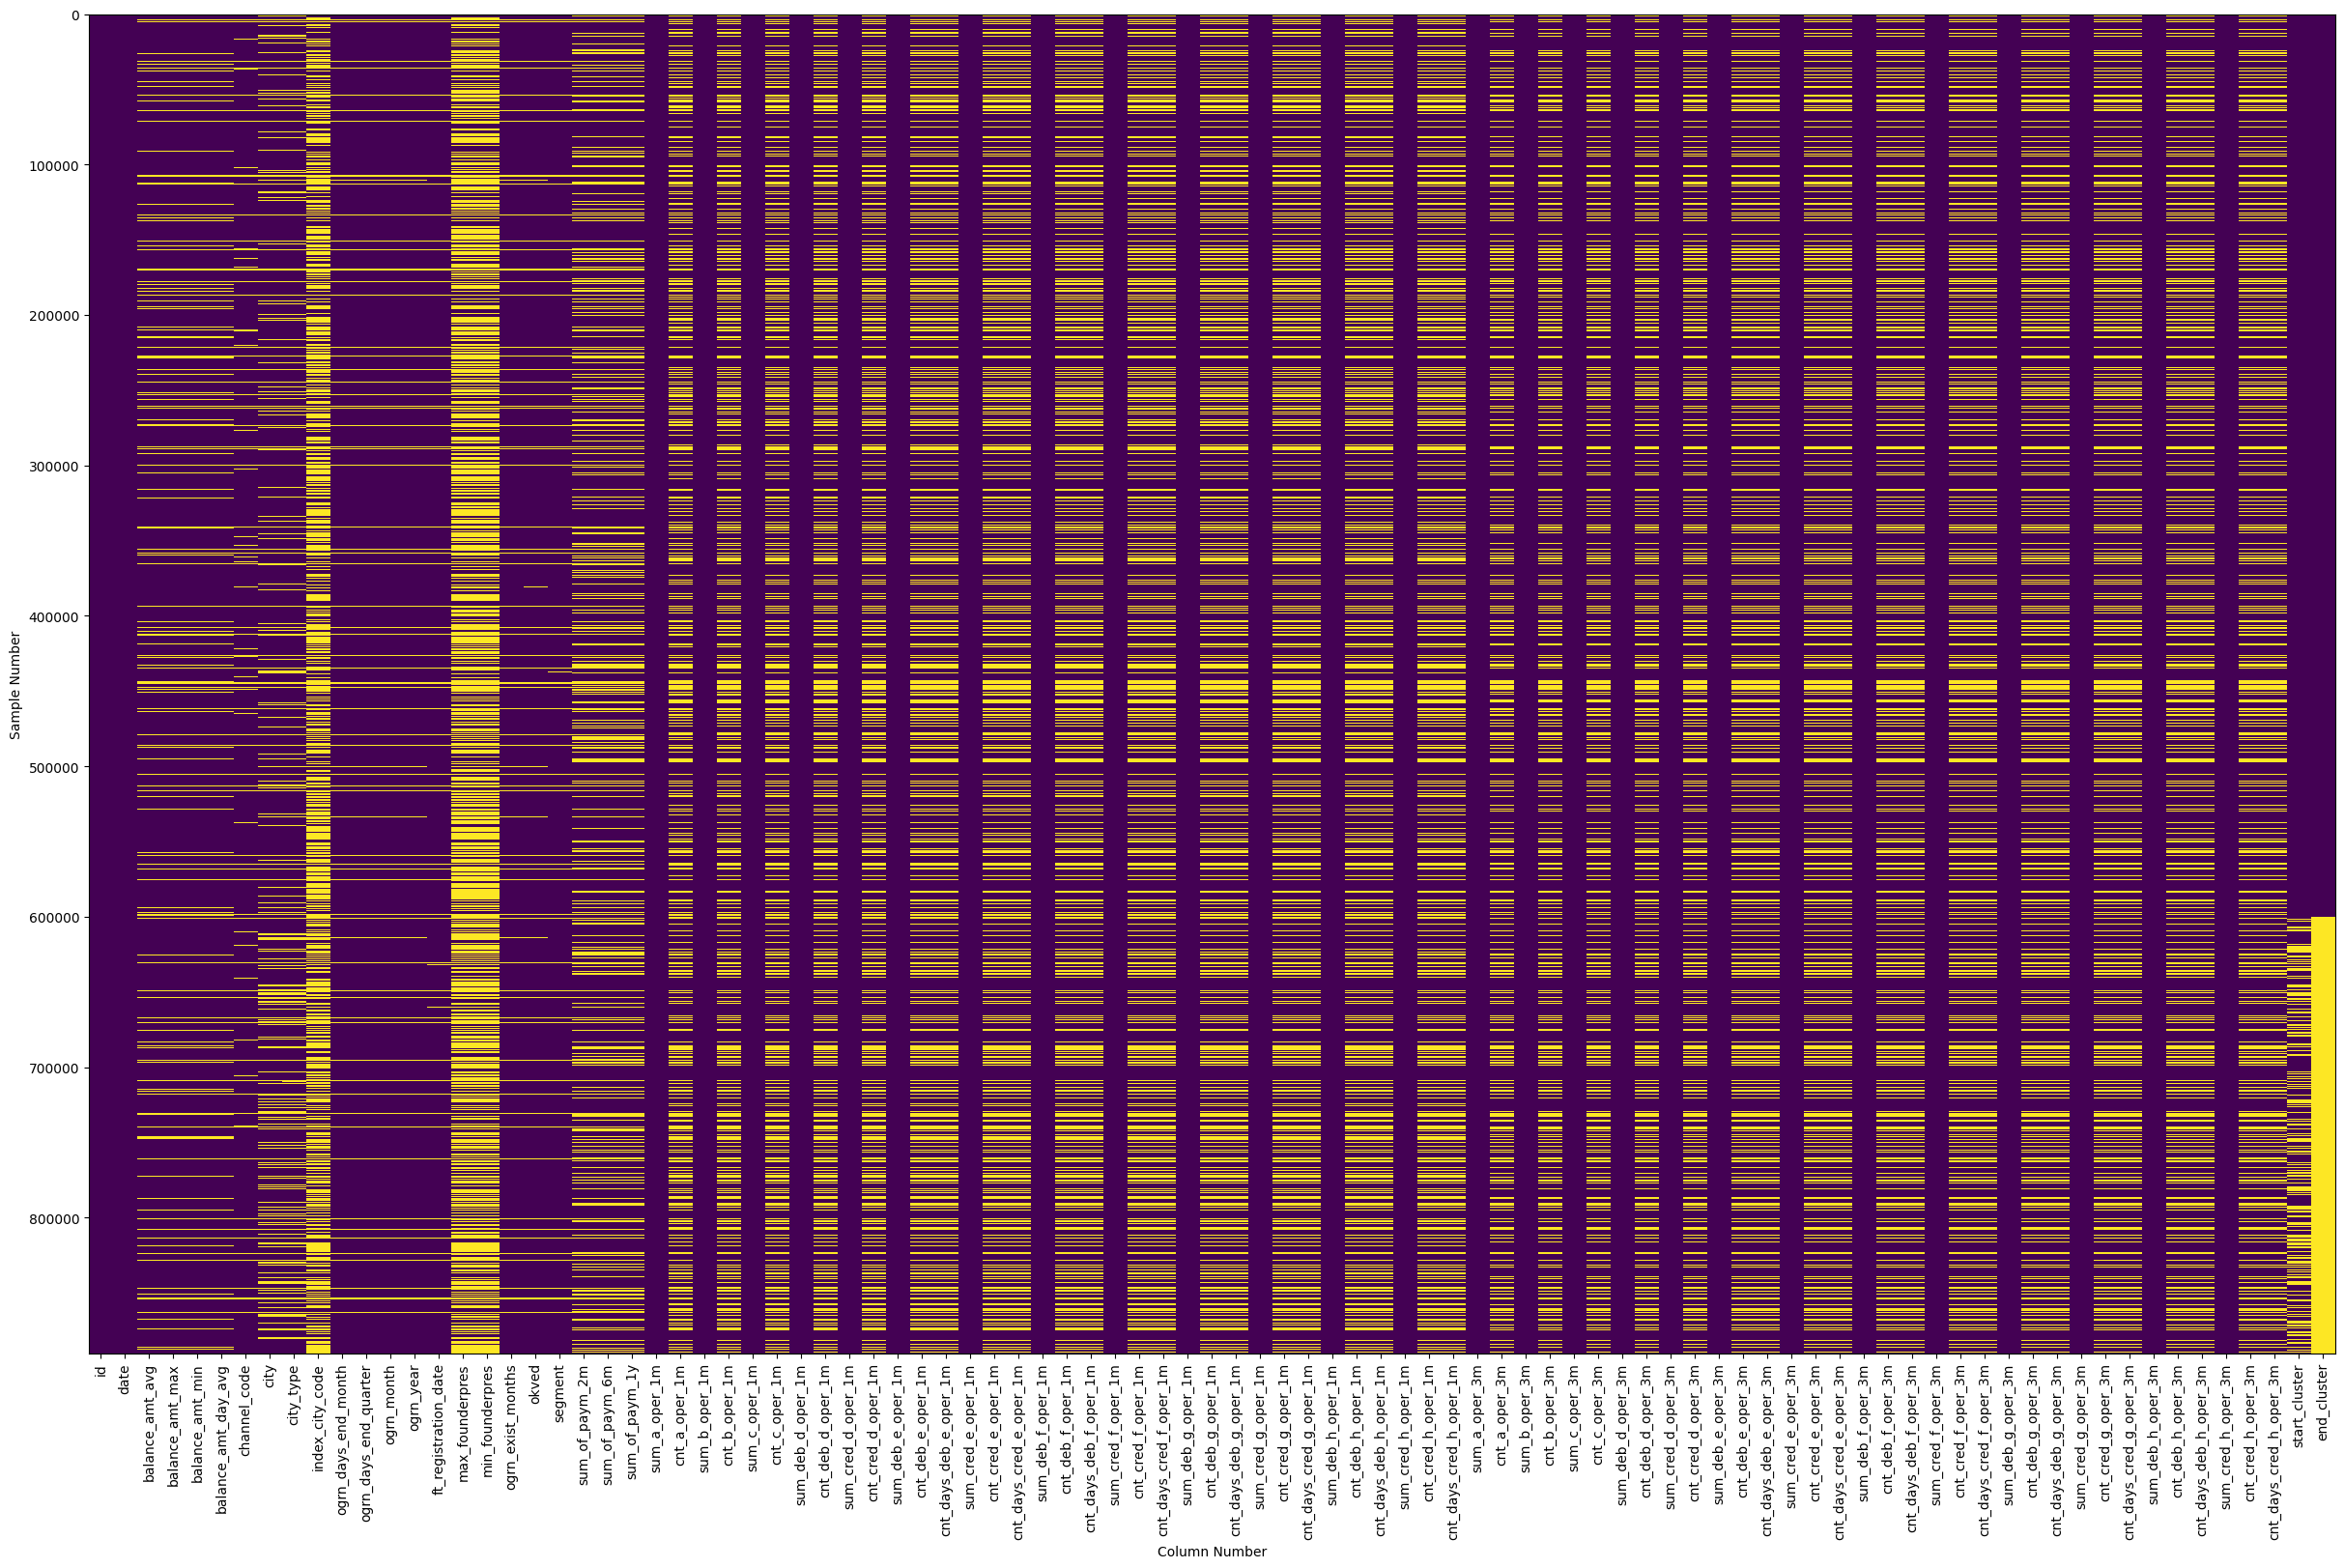

In [130]:
plt_null_df(df.isna())

In [131]:
df['sum_c_oper_1m'].value_counts()

sum_c_oper_1m
-0.1034    760706
-0.0951       345
-0.1017       284
-0.0992       173
-0.0868       173
            ...  
1.9482          1
3.2444          1
3.3239          1
0.3622          1
4.3110          1
Name: count, Length: 114740, dtype: int64

## Feature engineering

Тут кратко описание секции

In [132]:
def restore_cal(x):
    if x.isna().any() and not x.isna().all():
      return x.fillna(x.dropna().iloc[-1])
    return x

In [133]:
cat_columns_to_restore = ['channel_code', 'city',
                          'city_type', 'ogrn_month', 'ogrn_year', 'okved', 'segment']

for column in cat_columns_to_restore:
  df[column] = df.groupby('id')[column].apply(
      lambda x: restore_cal(x)).reset_index()[column]
  print(f"Колонка - {column} - восстановлена")

Колонка - channel_code - восстановлена
Колонка - city - восстановлена
Колонка - city_type - восстановлена
Колонка - ogrn_month - восстановлена
Колонка - ogrn_year - восстановлена
Колонка - okved - восстановлена
Колонка - segment - восстановлена


In [134]:
df.to_parquet("df_after_cat_restore.pqt")

In [188]:
df = pd.read_parquet("df_after_cat_restore.pqt")

###  AVG

Очень много плохих столбцов sum но  cnt хорошие и можно сгенирировать avg

In [191]:
# mean по датасету
numeric_cols = df.select_dtypes(include=['number']).columns[1:]
for col in numeric_cols:
    min_val = df[col].mean()
    df[col].fillna(min_val, inplace=True)

In [192]:
df

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}
2,0,month_3,0.6927,0.7403,0.4300,0.6957,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9465,0.4422,0.8770,0.5510,0.6632,0.8101,0.2948,0.9570,"{α, γ}",{other}
3,1,month_1,-0.0816,-0.0919,-0.1140,-0.0809,channel_code_2,city_14,city_type_0,None,...,0.9453,0.4078,0.3693,0.5671,0.7855,-0.1840,0.2535,0.4625,{other},{other}
4,1,month_2,-0.0950,-0.1005,-0.1193,-0.0943,channel_code_2,city_14,city_type_0,None,...,0.9461,0.4308,0.0673,0.5599,0.6966,-0.1839,0.2555,0.4954,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,month_5,-0.0067,-0.0068,-0.0065,-0.0068,channel_code_9,city_25,city_type_0,None,...,0.9462,0.4110,-0.1656,0.5512,0.5075,-0.2011,0.2553,0.4547,{},None
890116,299998,month_6,-0.1553,-0.2037,-0.1260,-0.1560,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.9445,0.3848,-0.1656,0.5469,0.4077,-0.2011,0.2509,0.3745,None,None
890117,299999,month_4,-0.1459,-0.1733,-0.1260,-0.1454,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0976,0.5509,0.5744,-0.1014,0.2527,0.4405,{α},None
890118,299999,month_5,-0.1364,-0.1639,-0.1215,-0.1359,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0479,0.5551,0.6966,-0.0349,0.2535,0.4734,{α},None


In [139]:
# filled_df = df.copy()
# for column in filled_df.select_dtypes(include=['number']).columns[1:]:  
#     filled_df[column] = filled_df.groupby('start_cluster')[column].transform(lambda x: x.fillna(x.mean()))


In [140]:
# filled_df = pd.DataFrame({
#     'feature1': [1, 2, None, 4, None],
#     'feature2': [None, 3, 4, 5, None],
#     'end_cluster': ['A', 'B', 'A', 'B', 'A']
# })

# # Группировка по 'end_cluster' и вычисление средних значений для каждого числового столбца
# mean_table = filled_df.groupby('end_cluster').mean()

# print(mean_table)

In [141]:
# mean_table = df.groupby('end_cluster').mean()

# print(mean_table['cnt_cred_e_oper_3m'])

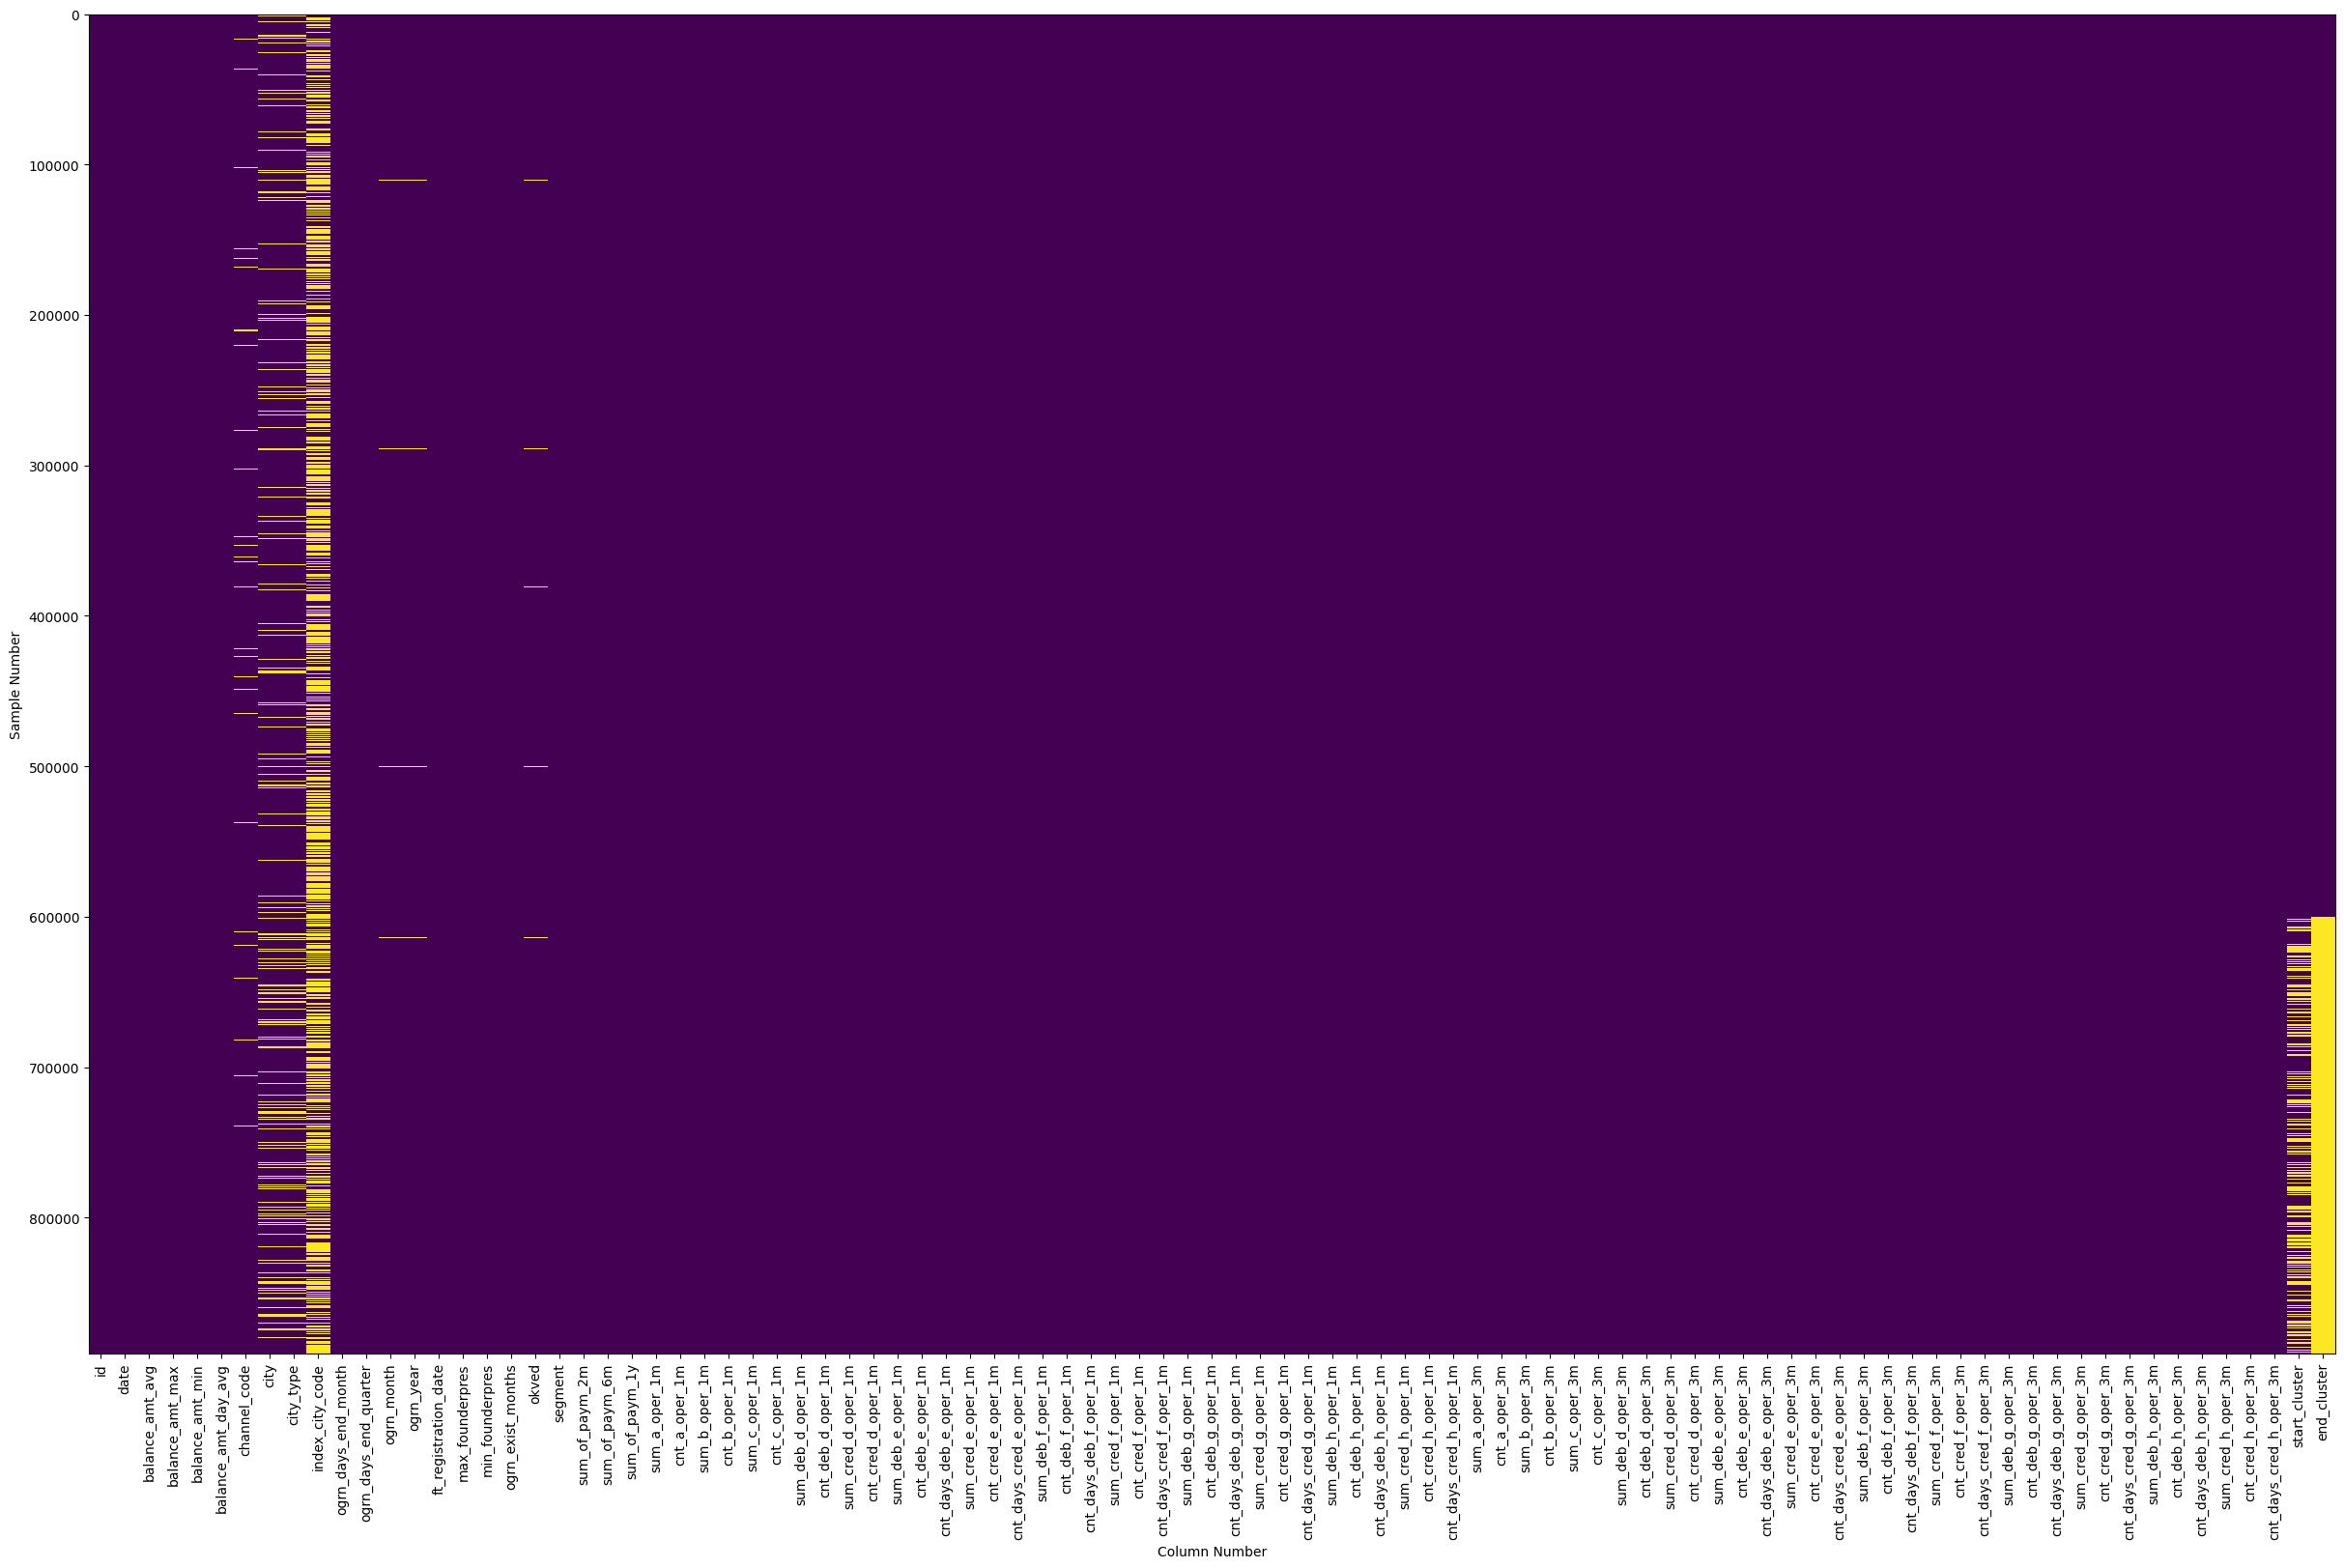

In [193]:
plt_null_df(df.isna())

In [144]:
# # mean по датасету по каждой категории
# numeric_cols = df.select_dtypes(include=['number']).columns[1:]
# for col in numeric_cols:
#     min_val = df[col].mean()
#     df[col].fillna(min_val, inplace=True)

In [194]:
df['avg_a_oper_1m'] = df['sum_a_oper_1m'] / df['cnt_a_oper_1m']
df['avg_b_oper_1m'] = df['sum_b_oper_1m'] / df['cnt_b_oper_1m']
df['avg_c_oper_1m'] = df['sum_c_oper_1m'] / df['cnt_c_oper_1m']

df['avg_deb_d_oper_1m'] = df['sum_deb_d_oper_1m'] / df['cnt_deb_d_oper_1m']
df['avg_cred_d_oper_1m'] = df['sum_cred_d_oper_1m'] / df['cnt_cred_d_oper_1m']

df['avg_deb_e_oper_1m'] = df['sum_deb_e_oper_1m'] / df['cnt_deb_e_oper_1m']
df['avg_cred_e_oper_1m'] = df['sum_cred_e_oper_1m'] / df['cnt_cred_e_oper_1m']


df['avg_deb_f_oper_1m'] = df['sum_deb_f_oper_1m'] / df['cnt_deb_f_oper_1m']
df['avg_cred_f_oper_1m'] = df['sum_cred_f_oper_1m'] / df['cnt_cred_f_oper_1m']

df['avg_deb_g_oper_1m'] = df['sum_deb_g_oper_1m'] / df['cnt_deb_g_oper_1m']
df['avg_cred_g_oper_1m'] = df['sum_cred_g_oper_1m'] / df['cnt_cred_g_oper_1m']

df['avg_deb_h_oper_1m'] = df['sum_deb_h_oper_1m'] / df['cnt_deb_h_oper_1m']
df['avg_cred_h_oper_1m'] = df['sum_cred_h_oper_1m'] / df['cnt_cred_h_oper_1m']


df['avg_a_oper_3m'] = df['sum_a_oper_3m'] / df['cnt_a_oper_3m']
df['avg_b_oper_3m'] = df['sum_b_oper_3m'] / df['cnt_b_oper_3m']
df['avg_c_oper_3m'] = df['sum_c_oper_3m'] / df['cnt_c_oper_3m']

df['avg_deb_d_oper_3m'] = df['sum_deb_d_oper_3m'] / df['cnt_deb_d_oper_3m']
df['avg_cred_d_oper_3m'] = df['sum_cred_d_oper_3m'] / df['cnt_cred_d_oper_3m']

df['avg_deb_e_oper_3m'] = df['sum_deb_e_oper_3m'] / df['cnt_deb_e_oper_3m']
df['avg_cred_e_oper_3m'] = df['sum_cred_e_oper_3m'] / df['cnt_cred_e_oper_3m']

df['avg_deb_f_oper_3m'] = df['sum_deb_f_oper_3m'] / df['cnt_deb_f_oper_3m']
df['avg_cred_f_oper_3m'] = df['sum_cred_f_oper_3m'] / df['cnt_cred_f_oper_3m']

df['avg_deb_g_oper_3m'] = df['sum_deb_g_oper_3m'] / df['cnt_deb_g_oper_3m']
df['avg_cred_g_oper_3m'] = df['sum_cred_g_oper_3m'] / df['cnt_cred_g_oper_3m']

df['avg_deb_h_oper_3m'] = df['sum_deb_h_oper_3m'] / df['cnt_deb_h_oper_3m']
df['avg_cred_h_oper_3m'] = df['sum_cred_h_oper_3m'] / df['cnt_cred_h_oper_3m']

In [195]:
df.to_parquet("df_after_cat_restore_fill_min.pqt")

In [196]:
df = pd.read_parquet("df_after_cat_restore_fill_min.pqt")

# df = pd.read_parquet("/kaggle/input/alfa-hackaton/df.pqt")

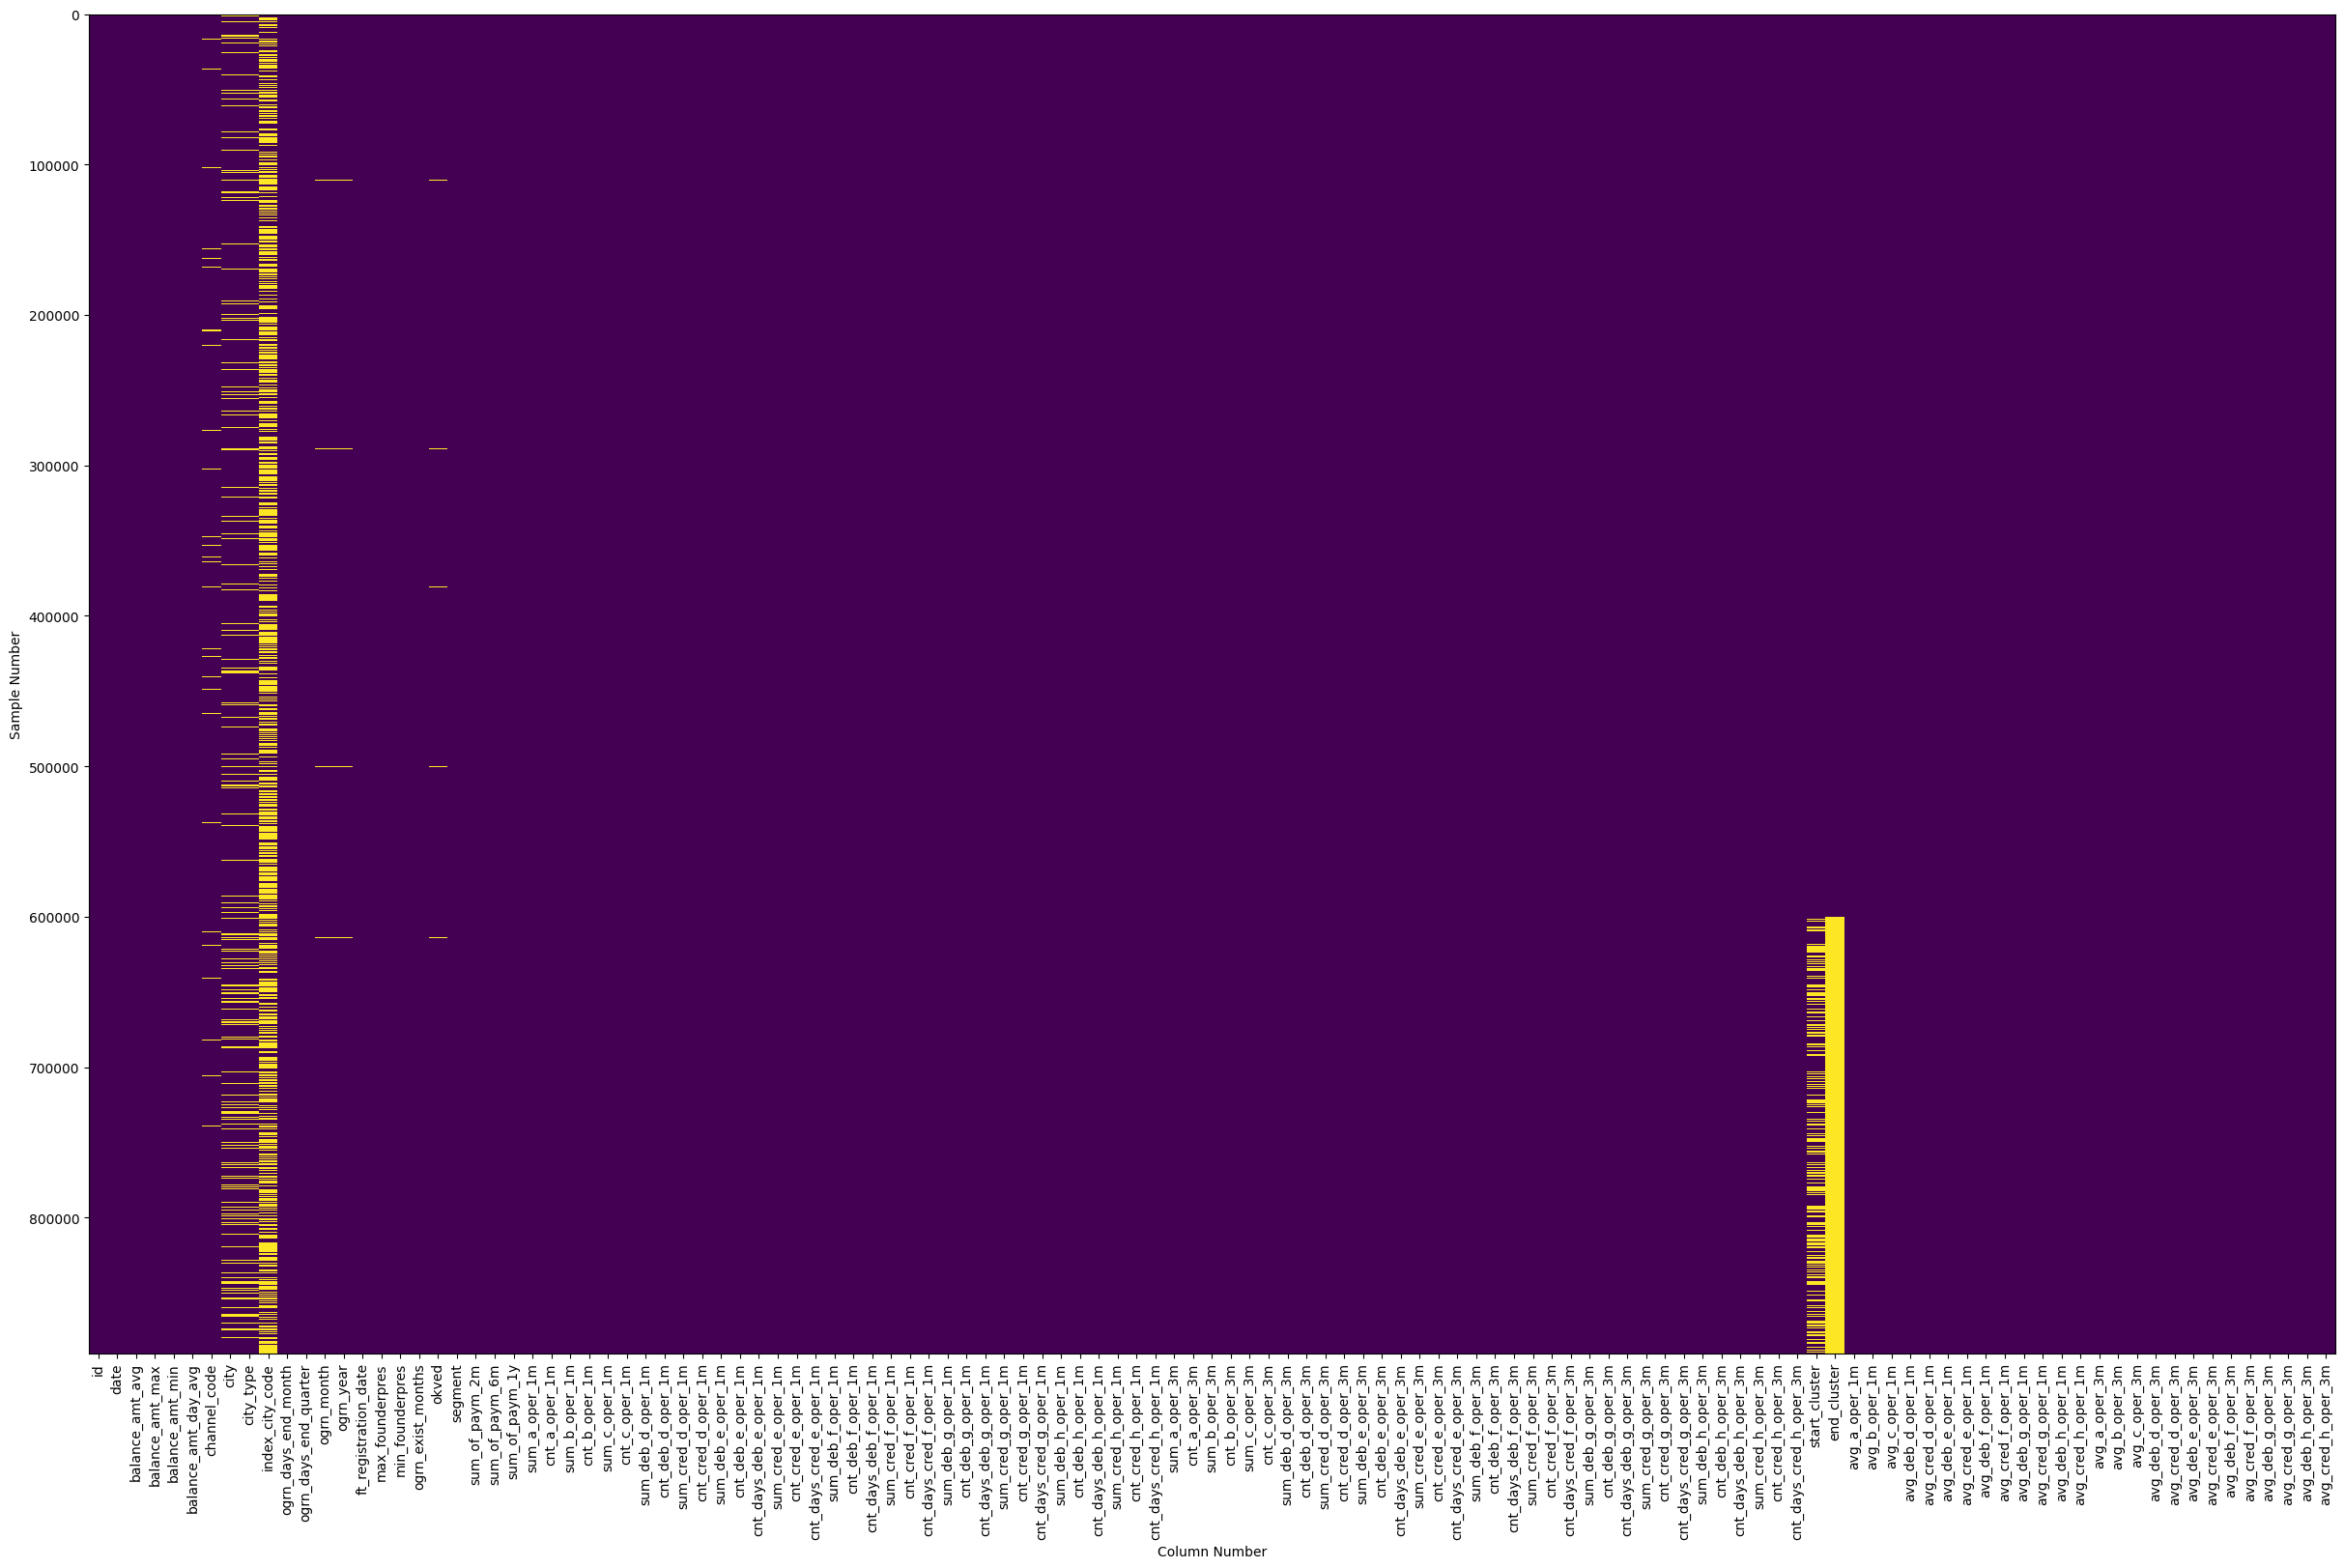

In [197]:
plt_null_df(df.isna())

In [149]:
# columns_to_drop = [
#     'balance_amt_max',
#     'balance_amt_min',
#     'balance_amt_day_avg',
#     'index_city_code',
#     'max_founderpres',
#     'min_founderpres',
#     'ogrn_exist_months',
#     'sum_a_oper_1m',
#     'sum_b_oper_1m',
#     'sum_c_oper_1m',
#     'sum_deb_d_oper_1m',
#     'sum_cred_d_oper_1m',
#     'sum_deb_e_oper_1m',
#     'sum_cred_e_oper_1m',
#     'sum_deb_f_oper_1m',
#     'sum_cred_f_oper_1m',
#     'sum_deb_g_oper_1m',
#     'sum_cred_g_oper_1m',
#     'sum_deb_h_oper_1m',
#     'sum_cred_h_oper_1m',
#     'sum_a_oper_3m',
#     'sum_b_oper_3m',
#     'sum_c_oper_3m',
#     'sum_deb_d_oper_3m',
#     'sum_cred_d_oper_3m',
#     'sum_deb_e_oper_3m',
#     'sum_cred_e_oper_3m',
#     'sum_deb_f_oper_3m',
#     'sum_cred_f_oper_3m',
#     'sum_deb_g_oper_3m',
#     'sum_cred_g_oper_3m',
#     'sum_deb_h_oper_3m',
#     'sum_cred_h_oper_3m']


# df = df.drop(columns=columns_to_drop)


# columns_to_drop = [
    
#     'index_city_code',
#     'max_founderpres',
#     'min_founderpres',
#     'ogrn_exist_months',
# ]


# df = df.drop(columns=columns_to_drop)

In [198]:
cat_cols = [
          "channel_code", "city", "city_type",
          "okved", "segment", "start_cluster", "ogrn_month", "ogrn_year",
      ]



df['date'] = df['date'].replace({'month_4': 'month_1', 'month_5': 'month_2', 'month_6': 'month_3'})

df[cat_cols] = df[cat_cols].astype("object")

### Создание таблицы с 3 месяцами

In [199]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "ogrn_month", "ogrn_year",
]

cat_cols_month_1 = [f'{col}_month_1' for col in cat_cols]
cat_cols_month_2 = [f'{col}_month_2' for col in cat_cols]



pivot_df = df.pivot_table(index='id', columns='date', aggfunc='first')

pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(
    columns=['end_cluster_month_1', 'end_cluster_month_2'] + cat_cols_month_1 + cat_cols_month_2, axis=0)

categorical_columns = pivot_df.select_dtypes(include=['object']).columns
pivot_df[categorical_columns] = pivot_df[categorical_columns].fillna("missing")

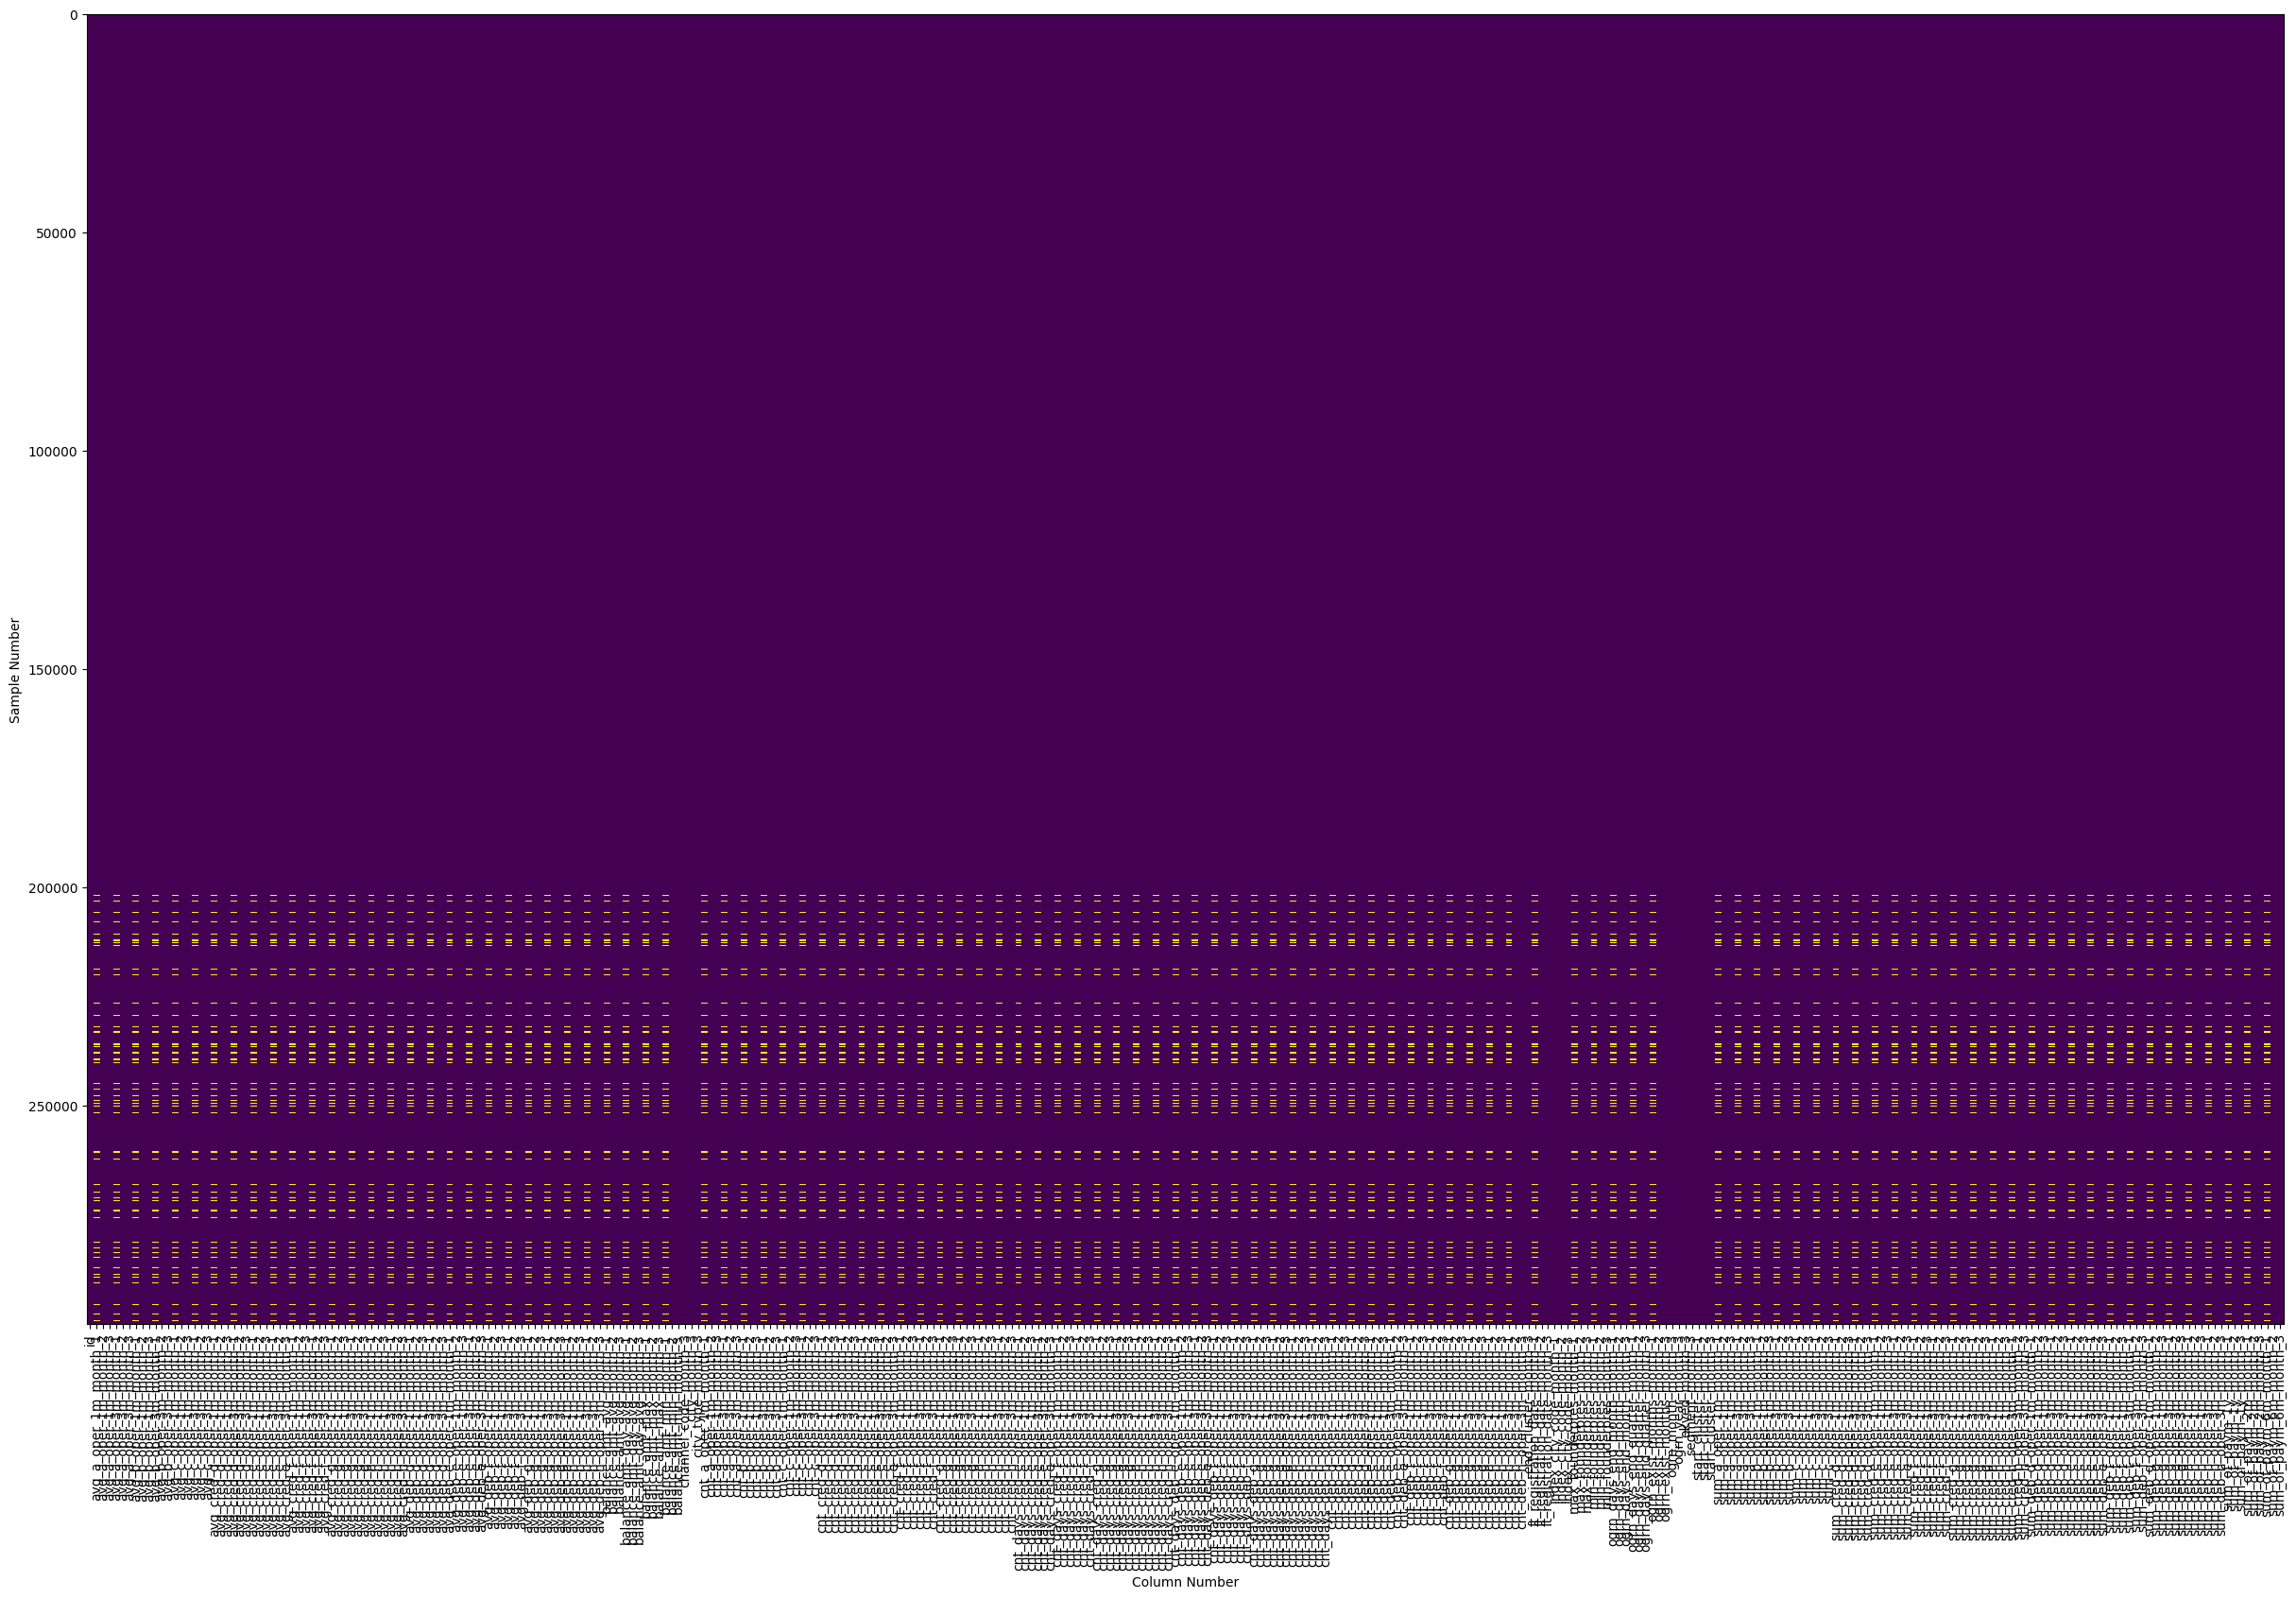

In [200]:
plt_null_df(pivot_df.isna())

In [201]:
# numeric_cols = pivot_df.select_dtypes(include=['number']).columns[1:]

# for i in range(0,len(numeric_cols) - 2,3):
#     col1 = numeric_cols[i]
#     col2 = numeric_cols[i + 1]
#     col3 = numeric_cols[i + 2]

#     col_name = "-".join(col1.split("_")[:-2])

#     pivot_df[f'{col_name}_diff_2_1'] = pivot_df[col2] - pivot_df[col1]

#     pivot_df[f'{col_name}_diff_3_2'] = pivot_df[col3] - pivot_df[col2]
    
#     pivot_df[f'{col_name}_mean'] = pivot_df[[col1, col2, col3]].mean(axis=1)
    

    
# # Сумма колличества операций
# cnt_columns = [col for col in df.columns if col.startswith('cnt')]
# df['all_cnt'] = df[cnt_columns].sum(axis=1)

# # Сумма операций 
# cnt_columns = [col for col in df.columns if col.startswith('sum')]
# df['all_sum'] = df[cnt_columns].sum(axis=1)

In [202]:
numeric_cols = pivot_df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    min_val = pivot_df[col].mean()
    pivot_df[col].fillna(min_val, inplace=True)
    

In [203]:
def remove_outliers(df, k=1.5):
    # Создаем копию DataFrame, чтобы избежать изменения исходного DataFrame
    df_cleaned = df.copy()

    # Итерируемся по каждому числовому столбцу
    for column in df_cleaned.select_dtypes(include='number').columns:
        # Вычисляем квартили
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)

        # Вычисляем межквартильный размах (IQR)
        IQR = Q3 - Q1

        # Определяем верхнюю и нижнюю границы для выбросов
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        # Заменяем значения за пределами границ на минимальное и максимальное значение
        df_cleaned[column] = df_cleaned[column].clip(
            lower=lower_bound, upper=upper_bound)

    return df_cleaned


# Применяем функцию к DataFrame, чтобы избавиться от выбросов
df = remove_outliers(df)

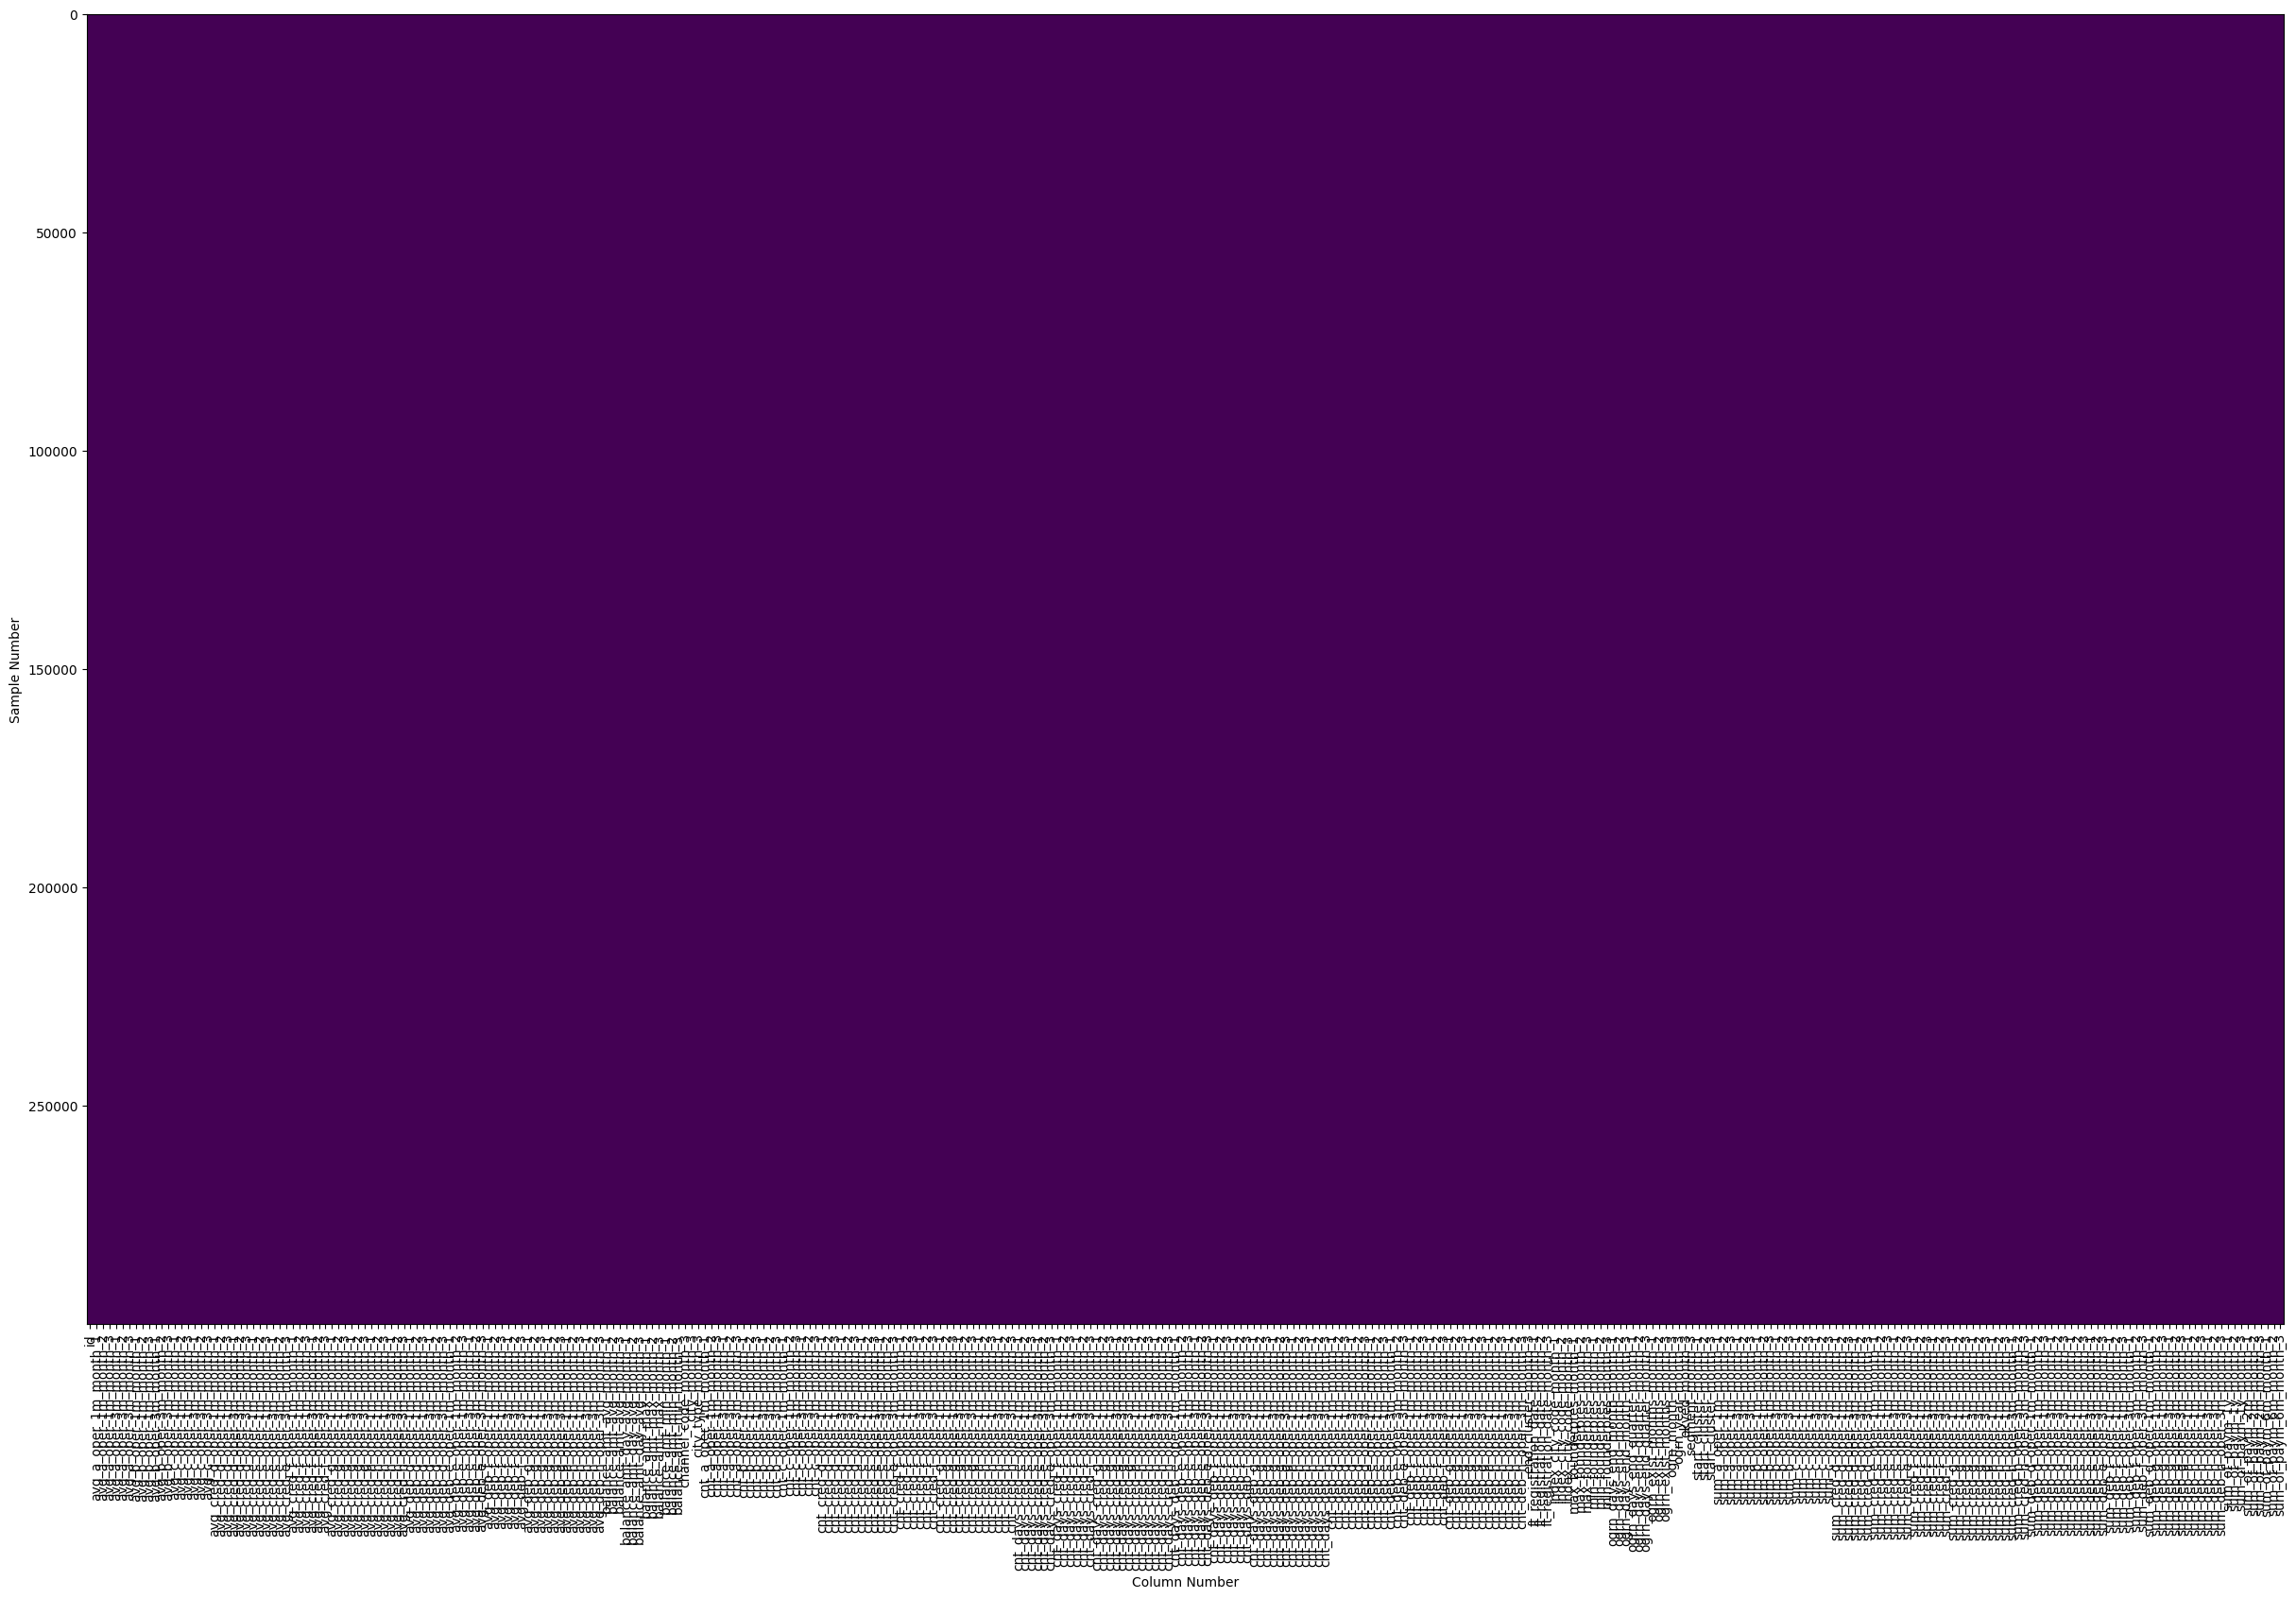

In [204]:
plt_null_df(pivot_df.isna())

In [205]:
df = pivot_df

### Воостановление start_claster

In [206]:
train_data = df[df['start_cluster_month_3'] != 'missing'].drop(
    ['id',  'end_cluster_month_3'], axis=1)
predict_data = df[df['start_cluster_month_3'] == 'missing'].drop(
    ['id', 'end_cluster_month_3'], axis=1)



# label_encoders = {}

# for col in cat_names:
#     label_encoders[col] = LabelEncoder().fit(df[col]) # !!!!!!!!!!!!!!!!!!

#     train_data[col] = label_encoders[col].transform(train_data[col])
#     predict_data[col] = label_encoders[col].transform(predict_data[col])
    
    

X = train_data.drop('start_cluster_month_3', axis=1)
y = train_data['start_cluster_month_3']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [207]:
# # Определение желаемого количества экземпляров каждого класса
# desired_class_count = 750  # Укажите ваше желаемое количество экземпляров

# # Обработка дисбаланса классов
# balanced_data = pd.DataFrame()
# for cluster in train_data['start_cluster_month_3'].unique():
#     cluster_data = train_data[train_data['start_cluster_month_3'] == cluster]
#     if len(cluster_data) < desired_class_count:
#         resampled_data = resample(
#             cluster_data, replace=True, n_samples=desired_class_count, random_state=42)
#     else:
#         resampled_data = cluster_data.sample(
#             n=desired_class_count, replace=False, random_state=42)
#     balanced_data = pd.concat([balanced_data, resampled_data])
# display(balanced_data['start_cluster_month_3'].value_counts())



# X = balanced_data.drop('start_cluster_month_3', axis=1)
# y = balanced_data['start_cluster_month_3']

# categorical_columns = X.select_dtypes(include=['object']).columns
# X[categorical_columns] = X[categorical_columns].fillna("missing")


#### CATBOOST

In [208]:
catboost_model_start_cluster = CatBoostClassifier(iterations=1024,
                           depth=6,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                           )

In [209]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
        x_train, y_train,
        cat_features=np.array(cat_names),
        eval_set=(x_val, y_val),
        verbose=100  # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_start_cluster.json')  # сохранение модели
    feature_importance = model.get_feature_importance(
        prettified=True)  # датасет с важностью признаков

    return feature_importance

In [210]:
cat_names = X.select_dtypes(include=['object']).columns

feature_importance = train_catboost(
    catboost_model_start_cluster, X_train, y_train, X_val, y_val, cat_names)

0:	learn: 1.9166973	test: 1.8946137	best: 1.8946137 (0)	total: 144ms	remaining: 2m 27s
100:	learn: 0.2481591	test: 0.2259391	best: 0.2259391 (100)	total: 6.39s	remaining: 58.4s
200:	learn: 0.2268877	test: 0.2142327	best: 0.2142327 (200)	total: 12.4s	remaining: 50.6s
300:	learn: 0.2191546	test: 0.2109280	best: 0.2109280 (300)	total: 18s	remaining: 43.3s
400:	learn: 0.2141711	test: 0.2090101	best: 0.2090101 (400)	total: 23.6s	remaining: 36.7s
500:	learn: 0.2099776	test: 0.2079334	best: 0.2079334 (500)	total: 29.3s	remaining: 30.6s
600:	learn: 0.2060914	test: 0.2069333	best: 0.2069333 (600)	total: 34.9s	remaining: 24.6s
700:	learn: 0.2023730	test: 0.2062876	best: 0.2062876 (700)	total: 40.7s	remaining: 18.7s
800:	learn: 0.1988536	test: 0.2056374	best: 0.2056367 (799)	total: 46.4s	remaining: 12.9s
900:	learn: 0.1958446	test: 0.2051953	best: 0.2051934 (899)	total: 52.1s	remaining: 7.11s
1000:	learn: 0.1926450	test: 0.2046696	best: 0.2046550 (997)	total: 57.9s	remaining: 1.33s
1023:	learn: 0

### lgb

In [211]:
# params_lgb = {
#     'objective': 'multiclass',
#     'num_class':17,
#     'metric': 'roc-auc',
#     'n_estimators': 500,
#     'class_weight': 'balanced',
#     'random_state': 47}

# model_lgb = LGBMClassifier(**params_lgb)

# verbose_eval = 50  # Определяет, как часто выводить метрики на валидационном наборе

# # Обучаем модель
# lgb_model = lgb.LGBMClassifier(**lgb_params, n_estimators=1024, device='gpu', early_stopping_rounds=20, verbose_eval=verbose_eval,  verbose=-1)

# lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])



In [212]:
y_pred = catboost_model_start_cluster.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

     {other}       0.93      0.92      0.92      2432
          {}       0.88      0.86      0.87      3847
      {α, β}       0.91      0.93      0.92       710
      {α, γ}       0.94      0.93      0.93      2274
      {α, δ}       0.86      0.86      0.86       575
   {α, ε, η}       0.92      0.89      0.90       125
   {α, ε, θ}       0.86      0.83      0.85        53
   {α, ε, ψ}       0.88      0.83      0.85        35
      {α, ε}       0.90      0.84      0.87       369
      {α, η}       0.96      0.97      0.97      3651
      {α, θ}       0.91      0.88      0.89       322
      {α, λ}       0.77      0.85      0.81        67
      {α, μ}       0.85      0.84      0.84        93
      {α, π}       0.00      0.00      0.00         1
      {α, ψ}       0.94      0.92      0.93       331
         {α}       0.96      0.97      0.97     25112
         {λ}       1.00      0.33      0.50         3

    accuracy              

In [213]:
X_predict = predict_data.drop('start_cluster_month_3', axis=1)
predicted_clusters = catboost_model_start_cluster.predict(X_predict)

In [214]:
predicted_clusters_flat = np.ravel(predicted_clusters)
class_counts = pd.Series(predicted_clusters_flat).value_counts()
print(class_counts)

{α}          68396
{α, η}        8033
{}            6709
{other}       5745
{α, γ}        5094
{α, β}        1968
{α, δ}        1342
{α, ε}         785
{α, θ}         699
{α, ψ}         447
{α, μ}         268
{α, ε, η}      201
{α, λ}         148
{α, ε, θ}      113
{α, ε, ψ}       44
{λ}              8
Name: count, dtype: int64


In [215]:
predicted_index = 0

df_restore_start_cluster = df.copy()
for index, row in df_restore_start_cluster.iterrows():
    # Проверяем, содержится ли в столбце 'date' значение 'month6' и id >= 100000
    if row['id'] >= 200000:
        # Вставляем значение из серии в столбец 'start_cluster_month_3' текущей строки
        df_restore_start_cluster.at[index,
                                    'start_cluster_month_3'] = predicted_clusters[predicted_index][0]
        # Увеличиваем индекс текущей строки в серии
        predicted_index += 1

In [216]:
matching_rows = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000].loc[(df_restore_start_cluster['start_cluster_month_1'] == df_restore_start_cluster['start_cluster_month_2']) & (
    df_restore_start_cluster['start_cluster_month_2'] == df_restore_start_cluster['start_cluster_month_3'])]
matching_rows

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,...,sum_deb_h_oper_3m_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3
200000,200000,1.2619,-0.1648,6.2595,4.4611,4.6360,5.4649,-0.0693,-0.0693,-0.0693,...,-0.1528,0.6766,0.6884,0.6719,0.4168,0.4332,0.2240,0.3324,0.2843,0.2854
200001,200001,-0.4493,-0.4493,-0.4493,-0.9794,-0.9794,-0.9794,-0.0690,-0.0690,-0.0690,...,-0.1656,0.0035,0.0035,0.0035,0.0017,0.0017,0.0017,-0.0015,-0.0015,-0.0015
200002,200002,9.3303,43.0412,24.7229,16.9913,45.0169,49.5095,-0.0693,-0.0693,-0.0693,...,2.6149,0.3656,0.9705,1.2116,1.3040,3.8709,4.1425,0.5504,1.6208,1.9696
200003,200003,-0.4493,-0.4493,-0.4493,-0.9794,-0.9794,-0.9794,-0.0690,-0.0690,-0.0690,...,-0.1656,0.0035,0.0035,0.0035,0.0017,0.0017,0.0017,-0.0015,-0.0015,-0.0015
200005,200005,0.6094,-0.0917,-0.4102,-0.0926,0.0646,0.0782,-0.0693,-0.0693,-0.0693,...,0.2455,0.4250,0.1547,0.2579,0.0450,0.0677,0.3984,0.2243,0.1523,0.2306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299994,299994,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,-0.2656,-0.2704,-0.2707,-0.2562,-0.2631,-0.2680,-0.2625,-0.2793,-0.2823
299995,299995,-0.4493,-0.4493,-0.4493,-0.9794,-0.9794,-0.9794,-0.0690,-0.0690,-0.0690,...,-0.1656,-0.2961,-0.2961,-0.2961,-0.2740,-0.2740,-0.2740,-0.2946,-0.2946,-0.2946
299996,299996,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1558,-0.2894,-0.2898,-0.2875,-0.2735,-0.2720,-0.2599,-0.2845,-0.2838,-0.2842
299997,299997,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.0879,-0.1378,-0.1119,-0.0847,-0.0707,-0.0416,-0.0087,-0.0990,-0.0826,-0.0688


In [217]:
df.to_parquet("df_after_start_restore.pqt")

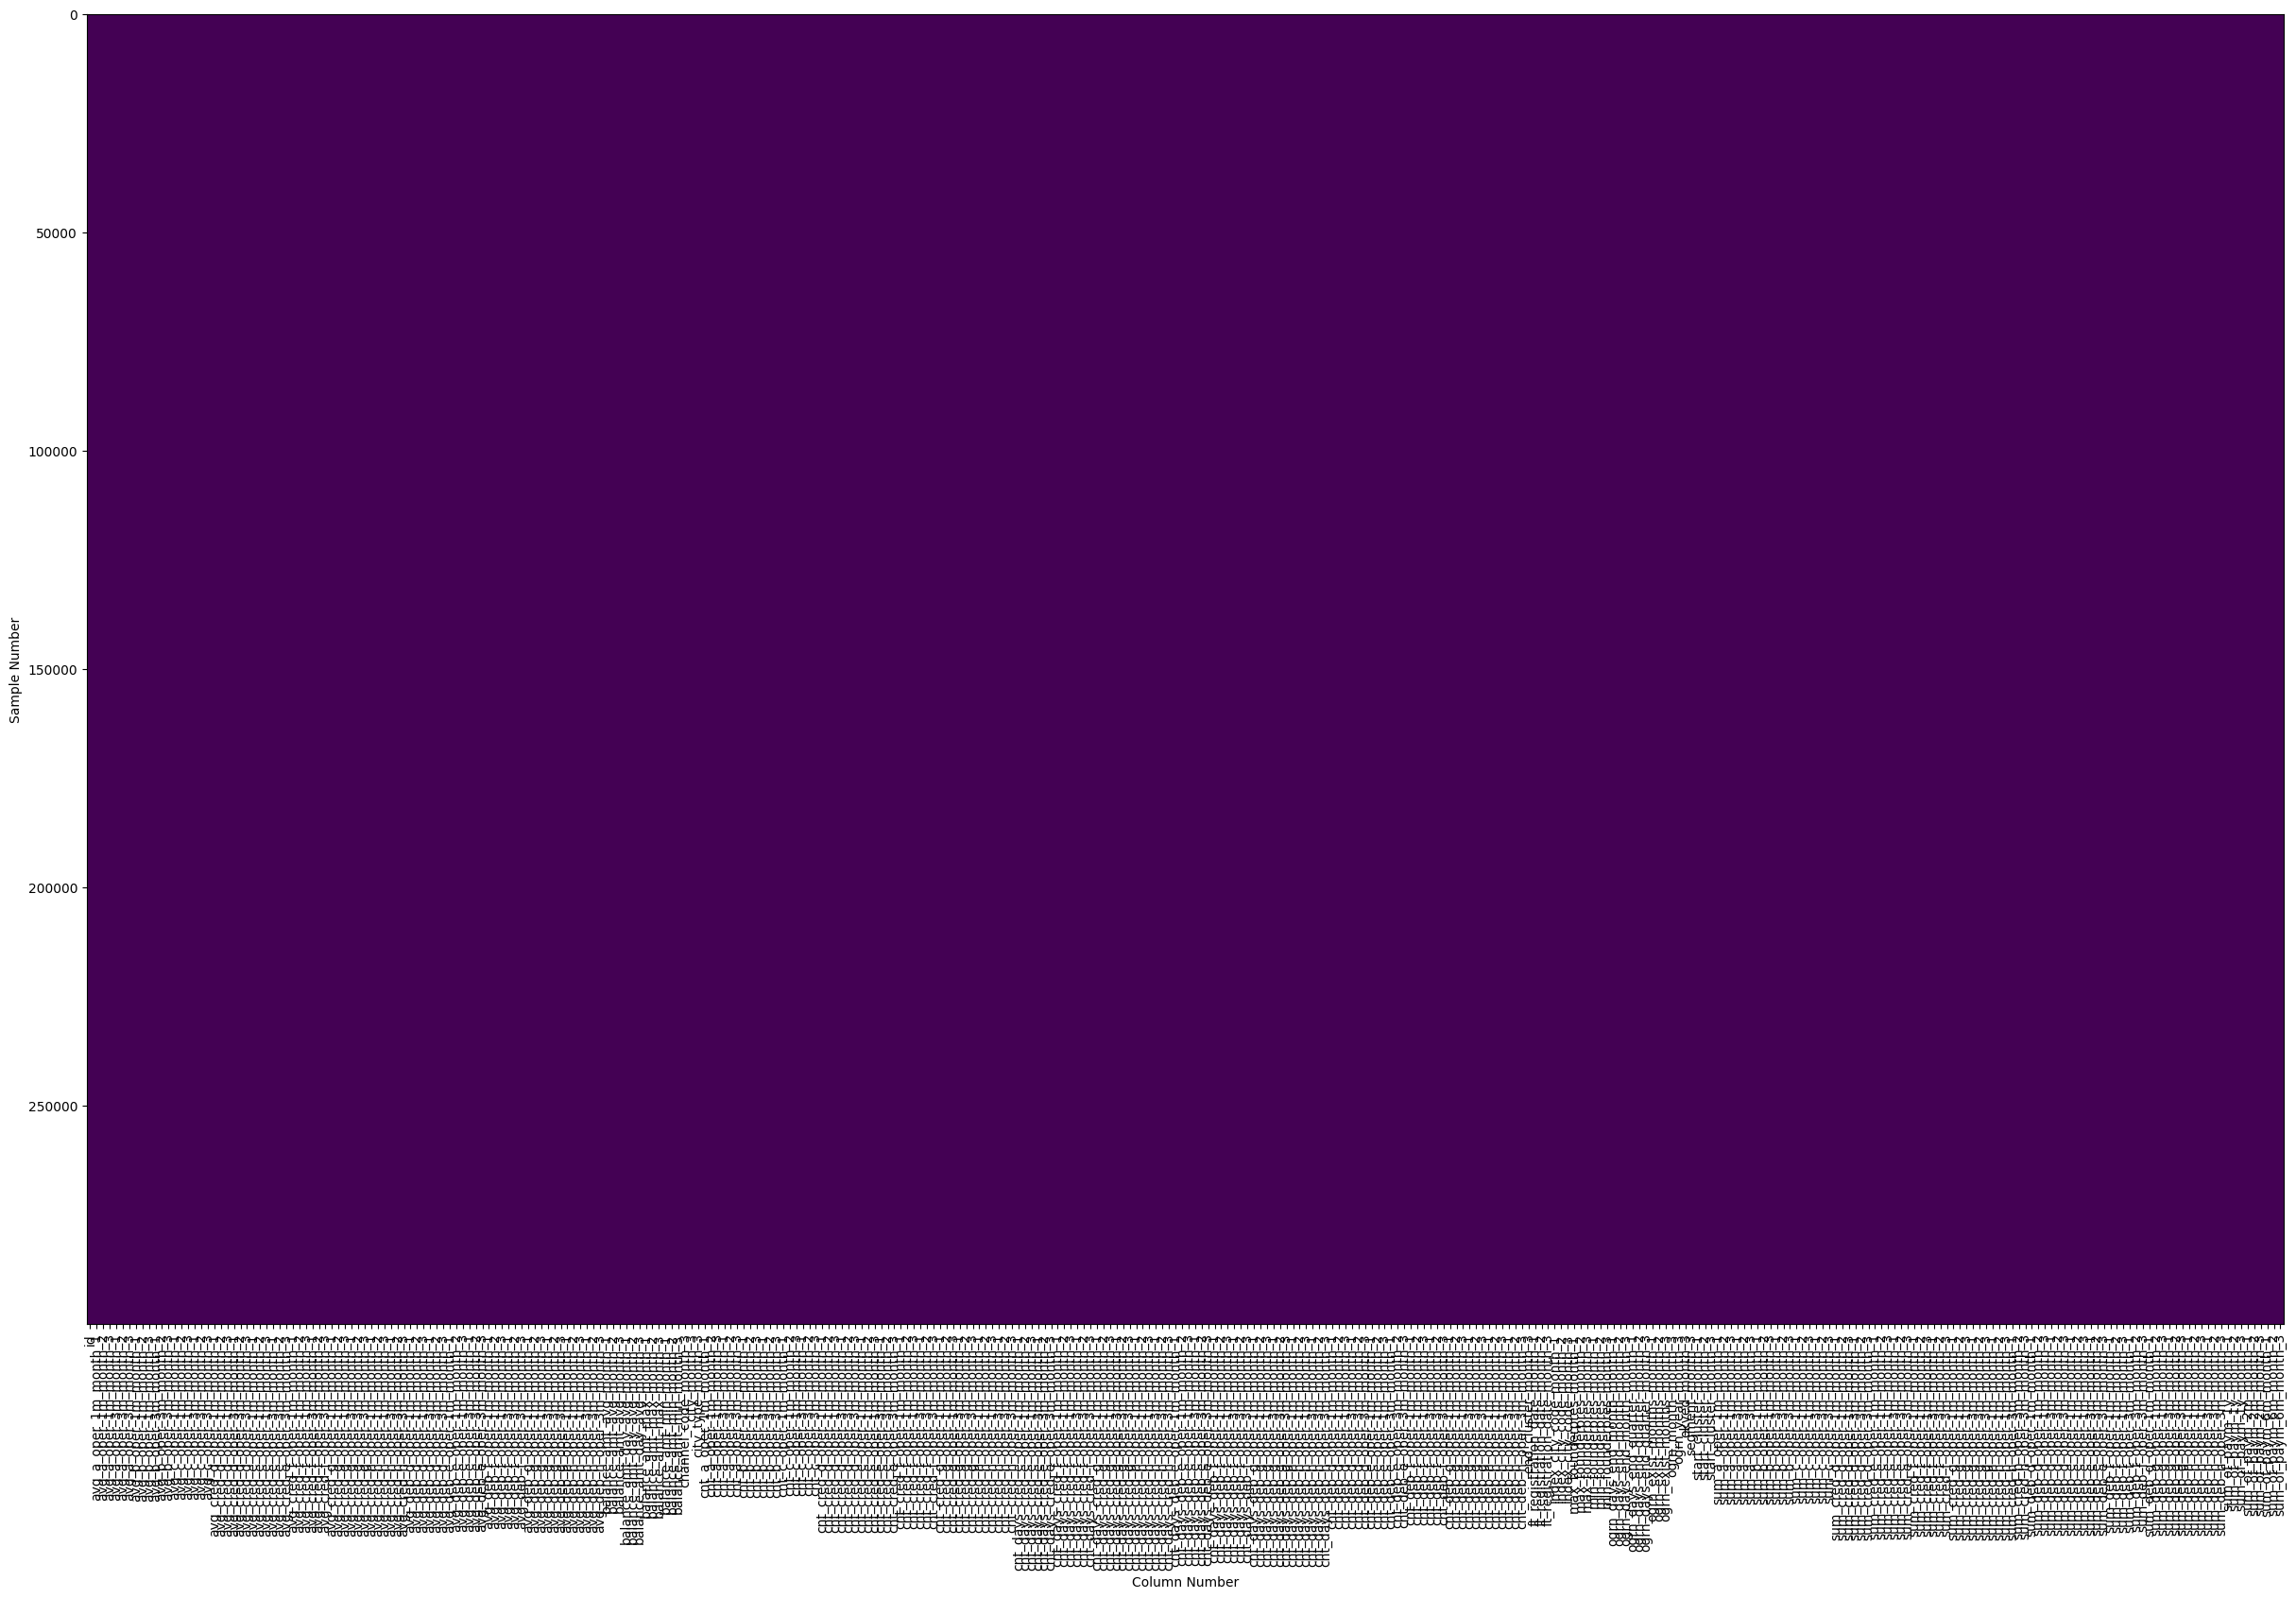

In [218]:
plt_null_df(df_restore_start_cluster.isna())

## Обучение модели <a class="anchor" id="first-bullet"></a>

In [219]:
train_df = df_restore_start_cluster[df_restore_start_cluster['id']< 200000]
test_df = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000]

X = train_df.drop(["id"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
y = train_df["end_cluster_month_3"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [220]:
x_train['end_cluster_month_3'].value_counts()

end_cluster_month_3
{α}          84479
{}           33282
{other}      13280
{α, η}       10016
{α, γ}        9022
{α, β}        2934
{α, θ}        1785
{α, ε}        1476
{α, δ}        1432
{α, ψ}         664
{α, μ}         587
{α, ε, η}      400
{α, ε, θ}      297
{α, λ}         218
{α, ε, ψ}       79
{λ}             45
{α, π}           4
Name: count, dtype: int64

In [221]:
y_train = x_train['end_cluster_month_3']
x_train = x_train.drop(['end_cluster_month_3'], axis=1)
x_val = x_val.drop(['end_cluster_month_3'], axis=1)

display(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(160000, 334)

(160000,)

(40000, 334)

(40000,)

In [222]:
catboost_model_end_cluster = CatBoostClassifier(iterations=2025,
                           depth=6,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                          )


In [223]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=100 # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_end_claster.json') # сохранение модели
    feature_importance = model.get_feature_importance(prettified=True) # датасет с важностью признаков

    return feature_importance

In [224]:
cat_names = x_train.select_dtypes(include=['object']).columns



feature_importance = train_catboost(catboost_model_end_cluster, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.2483055	test: 2.2032295	best: 2.2032295 (0)	total: 123ms	remaining: 4m 8s
100:	learn: 0.8389839	test: 0.7675744	best: 0.7675744 (100)	total: 7.2s	remaining: 2m 17s
200:	learn: 0.8107582	test: 0.7524186	best: 0.7524186 (200)	total: 13.8s	remaining: 2m 5s
300:	learn: 0.7946258	test: 0.7469841	best: 0.7469841 (300)	total: 20.4s	remaining: 1m 56s
400:	learn: 0.7829651	test: 0.7443097	best: 0.7443005 (399)	total: 26.8s	remaining: 1m 48s
500:	learn: 0.7725201	test: 0.7428080	best: 0.7428046 (499)	total: 33.1s	remaining: 1m 40s
600:	learn: 0.7632695	test: 0.7414815	best: 0.7414815 (600)	total: 39.5s	remaining: 1m 33s
700:	learn: 0.7548375	test: 0.7403145	best: 0.7403145 (700)	total: 45.8s	remaining: 1m 26s
800:	learn: 0.7467391	test: 0.7396310	best: 0.7396025 (797)	total: 52.1s	remaining: 1m 19s
900:	learn: 0.7388356	test: 0.7392987	best: 0.7392987 (900)	total: 58.4s	remaining: 1m 12s
1000:	learn: 0.7310425	test: 0.7389379	best: 0.7389271 (996)	total: 1m 4s	remaining: 1m 6s
1100:	

In [225]:
feature_importance

,Feature Id,Importances
0,start_cluster_month_3,8.4888
1,okved_month_3,5.2330
2,city_month_3,3.6407
3,index_city_code_month_3,3.5524
4,segment_month_3,3.3233
...,...,...
329,cnt_days_cred_g_oper_1m_month_2,0.0000
330,city_type_month_3,0.0000
331,cnt_b_oper_1m_month_2,0.0000
332,cnt_days_cred_f_oper_3m_month_2,0.0000


## Тестирование модели

In [226]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [227]:
cluster_weights = pd.read_excel("/kaggle/input/alfa-hackaton/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [228]:
y_pred_proba = catboost_model_end_cluster.predict_proba(x_val)
weighted_roc_auc(y_val, y_pred_proba, catboost_model_end_cluster.classes_, weights_dict)

0.9198544864622821

Прогноз на тестовой выборке

In [229]:
sample_submission_df = pd.read_csv("/kaggle/input/alfa-hackaton/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop(["id" , 'end_cluster_month_3'], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = catboost_model_end_cluster.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=catboost_model_end_cluster.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_9.csv", index=False) # сохранение модели

In [182]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.0163,0.6277,0.0038,0.0075,0.0027,0.0006,0.0018,0.0011,0.0014,0.0056,0.0073,0.0003,0.0014,0.0001,0.0021,0.3203,0.0002
1,200001,0.0192,0.4915,0.0021,0.0056,0.0014,0.0014,0.0014,0.0002,0.0009,0.0094,0.0024,0.0014,0.0027,0.0000,0.0015,0.4587,0.0001
2,200002,0.1238,0.3868,0.0057,0.0295,0.0044,0.0010,0.0034,0.0052,0.0038,0.0180,0.0053,0.0040,0.0015,0.0003,0.0132,0.3934,0.0007
3,200003,0.0323,0.4372,0.0015,0.0029,0.0013,0.0032,0.0012,0.0003,0.0015,0.0451,0.0036,0.0001,0.0022,0.0000,0.0016,0.4657,0.0000
4,200004,0.0841,0.4836,0.0024,0.0108,0.0019,0.0010,0.0002,0.0005,0.0029,0.0260,0.0017,0.0011,0.0097,0.0001,0.0016,0.3723,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.0378,0.3438,0.0126,0.0146,0.0081,0.0003,0.0010,0.0002,0.0017,0.0047,0.0026,0.0011,0.0014,0.0000,0.0041,0.5657,0.0002
99996,299996,0.0320,0.4433,0.0075,0.0168,0.0057,0.0003,0.0005,0.0005,0.0022,0.0050,0.0092,0.0020,0.0015,0.0000,0.0032,0.4700,0.0003
99997,299997,0.0167,0.3121,0.0051,0.0137,0.0055,0.0004,0.0013,0.0013,0.0025,0.0097,0.0063,0.0006,0.0018,0.0001,0.0055,0.6173,0.0002
99998,299998,0.0342,0.5481,0.0057,0.0168,0.0023,0.0004,0.0004,0.0005,0.0028,0.0053,0.0039,0.0038,0.0029,0.0001,0.0035,0.3689,0.0004


---
## Выводы и резюме

Мы решали **задачу прогнозирования временного ряда спроса товаров** собственного производства на 14 дней вперёд.

Заказчиком предоставлены исторические данные о **продажах за 1 год**, а также в закодированном виде товарная иерархия и информация о магазинах.  
Прогнозировалось **число проданных товаров в штуках  `pr_sales_in_units`** для каждого **SKU/товара** (2050 шт. в обучающей выборке) в каждом из **10 магазинов**.

Основные **закономерности**, выявленные в результате анализа:
- ***Годовой тренд***  - спад средних продаж в зимний сезон октябрь-март.
- ***Недельная сезонность*** - пик продаж в субботу, спад в понедельник.
- В течение года несколько высоких ***пиков спроса, в основном в районе праздников***. Самые резкие подъёмы продаж в период Нового года и Пасхи. Подъем продаж начинается за несколько дней до.
- 40,6% записей относятся к продажам по промоакциям. Возможны одновременные продажи товара в одном магазине по промо и без.
- В данных представлены продукты с ***неполными временными рядами***: продавались только в дни около Пасхи, начали продаваться полгода назад.
- Во всех магазинах разный ассортимент товаров даже при условии одинаковых характеристик торговой точки.
- Все мета-признаки как характеристики магазинов и товаров показали влияние на средний спрос

На основе имеющихся данных **сгенерированы новые признаки:**  
- Календарные: день недели, число месяца, номер недели, флаг выходного дня (взят из доп. таблицы)
- Лаговые признаки 1-30 дней
- Скользящее среднее за 7 и 14 предыдущих дней
- Кластеризация по характеристикам магазинов и товаров
    
Чтобы временные ряды каждой комбинации Магазин-Товар были полными создан новый датасет, в который добавлены отсутствующие даты с нулевыми продажами.

 Обучение, валидация и выбор лучшего набора гиперпараметров проводится на **кросс-валидации Walk Forward**: подбор гиперпараметров на фолде проводится на valid-выборке, оценка лучшей модели на фолде на test-выборке.   
В итоге выбрана одна модель среди лучших на каждом фолде.

 Предсказание спроса обученной моделью делается последовательно на каждый следующий день с промежуточным перерасчётом лаговых признаков (учитывается предсказанное значение спроса в предыдущий день).

 Для оценки модели использовалась метрика качества  **WAPE**, посчитанная на уровне Магазин-Товар-Дата.  

Лучший результат по качеству и скорости показала модель градиентного бустинга **LightGBM**.  <br>
Полученный результат: WAPE = **0,47**, превышает baseline (предсказание последним известным значением) с метрикой 69%.


